# Click-Through Rate Prediction

> In online advertising, click-through rate (CTR) is a very important metric for evaluating ad performance. As a result, click prediction systems are essential and widely used for sponsored search and real-time bidding.
>
> [Competition page](https://www.kaggle.com/c/avazu-ctr-prediction)

Todo:
 * Complement plot's labels

## Libraries

 * **Numpy:** Useful for algebra and other mathematical utilities
 * **Pandas:** Library that enables working with dataframes
 * **Dask:** Provides functionality that mimics numpy arrays and pandas dataframes, while performing out-of-core computations
 * **Matplotlib:** Useful for fast and non-interactive visualizations
 * **Plotly:** Visualization library, with a lot of interactive functionality
 * **Sci-kit Learn:** Library with machine learning algorithms, useful, e.g., for exploratory and predictive data analysis

Start by clearing variables from previous runs 

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn

Set Matplotly and Plotly to be used inline throughou the notebook:

In [3]:
# Matplotlib
%matplotlib inline

# Pyplot
init_notebook_mode(connected=True)

Beautify Matplotlib:

In [4]:
matplotlib.style.use('ggplot')

Import the dataset using Pandas dataframes, with proper configuration:

In [5]:
date_parser = lambda x: pd.datetime.strptime(x, '%y%m%d%H')

These are the datatypes for the data features. These were obtained through a previous observation of the data contents, and in the case of integers, of the integers feature ranges.

In [6]:
data_types = {
    'id': np.str,
    'click': np.bool_,
    'hour': np.str,
    'C1': np.uint16,
    'banner_pos': np.uint16,
    'site_id': np.object,
    'site_domain': np.object,
    'site_category': np.object,
    'app_id': np.object,
    'app_domain': np.object,
    'app_category': np.object,
    'device_id': np.object,
    'device_ip': np.object,
    'device_model': np.object,
    'device_type': np.uint16,
    'device_conn_type': np.uint16,
    'C14': np.uint16,
    'C15': np.uint16,
    'C16': np.uint16,
    'C17': np.uint16,
    'C18': np.uint16,
    'C19': np.uint16,
    'C20': np.uint16,
    'C21': np.uint16    
}

Now we have to load the training dataset. It is already ordered chronologically. 
Functionality that can be reused will be enclosed into functions, and transformations to dataframes will be performed inplace, to preserve memory.

In [7]:
def load_train_data():
    train_df = pd.read_csv('./data/train/train.csv',
                           dtype=data_types,
                           parse_dates=['hour'],
                           date_parser=date_parser)
    return train_df

In [8]:
%%time
train_df = load_train_data()

Wall time: 11min 42s


Extract some basic information about the data

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
id                  object
click               bool
hour                datetime64[ns]
C1                  uint16
banner_pos          uint16
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type         uint16
device_conn_type    uint16
C14                 uint16
C15                 uint16
C16                 uint16
C17                 uint16
C18                 uint16
C19                 uint16
C20                 uint16
C21                 uint16
dtypes: bool(1), datetime64[ns](1), object(10), uint16(12)
memory usage: 260.8+ MB


We have a little more than 40 million examples to work with, 
It is possible to see that, through data type specification, we are able to reduce the data memory footprint to 260.8 MB. (This could be lowered even more by taking the object data types, and substitute them by integers that keep the same identity.)

Now we can visualize some examples:

In [10]:
train_df.iloc[:, :12].head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id
0,1000009418151094273,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
1,10000169349117863715,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
2,10000371904215119486,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
3,10000640724480838376,False,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a
4,10000679056417042096,False,2014-10-21,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a


In [11]:
train_df.iloc[:, 12:].head()

,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,65535,79
1,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,34548,79
2,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,34548,79
3,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,34548,79
4,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,65535,157


The target for the prediction task is the 'click' column. We have a mixture of time-based and categorical features available, that will be explored next.

## Exploratory Data Analysis and Feature Engineering

This section seeks to explore each feature we have available, as well as relationships between them and the target variable. The objective here is to gain some intuition over the data, whether it is, e.g., through statistics or visualizations. Provided with this knowledge, new features may be derived, that will (hopefully) help our prediction task down the road.

### *id*
This feature raises the question if it is unique accross the dataset. If that is true, it does not provide any information that may be interesting for our task, as no two examples may be compared through it.

In [12]:
train_df.shape[0] == train_df['id'].unique().shape[0]

True

As that is true, it can be removed this column from the dataframe:

In [13]:
def remove_id_col(df):
    df.drop('id', axis=1, inplace=True)
    return df

In [14]:
train_df = remove_id_col(train_df)

### *click*
This is the target variable. It is useful to know how it is distributed throghout the data:

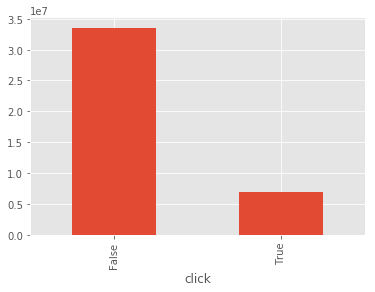

In [15]:
train_df.groupby('click').size().plot(kind='bar')

In [16]:
train_df['click'].value_counts() / train_df.shape[0]

False    0.830194
True     0.169806
Name: click, dtype: float64

The label more represented in the dataset is for no-clicks in ads (which was expected from a real-world dataset), which accounts for arround 83% of the data.
The fact that we are dealing with an unballanced dataset should be taken into account down the road, by using stratified sampling in separating the training and test datasets, using stratified k-fold cross-validation, resample examples to balance the dataset, and, when applicable, provide hyperparameters to the classifiers that changes how they weight each example.

###  *hour*
Each event has associated a timestamp, with precision up to the hour.
Lets start by determining the datetime range

In [17]:
train_df.hour.describe()

count                40428967
unique                    240
top       2014-10-22 09:00:00
freq                   447783
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

The dataset starts on a Tuesday, and ends on a Thursday (test data corresponds to a Friday then).

Time features are naturally thought about in terms of cycles: day-night, hours of the day, day of the week, etc. Lets then derive the features: day of the week and hour of day, which may be the ones that vary enough in the dataset small time-frame to capture interesting patterns, as well as a feature that is essentially a convertion from hours to integers (grow as the hour grows). The function also return the hour it used to start the hours counter (useful when deriving features in the test dataset).

In [18]:
def derive_time_features(df, start_hour=None, remove_original_feature=False):
    if start_hour is None:
        start_hour = df['hour'][0]
        
    df['hour_int'] = train_df['hour'].apply(lambda x: np.floor((x - start_hour) / np.timedelta64(1, 'h')).astype(np.uint16))
    df['day_week'] = train_df['hour'].apply(lambda x: x.dayofweek)
    df['hour_day'] = train_df['hour'].apply(lambda x: x.hour)
    
    if remove_original_feature:
        df.drop('hour', axis=1, inplace=True)
    
    return df, start_hour

In [19]:
train_df, _ = derive_time_features(train_df)

Now lets visualize those derived features:

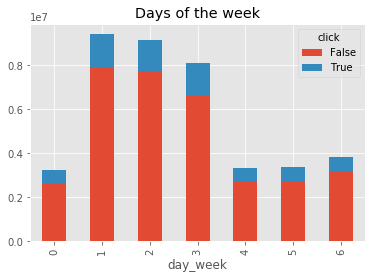

In [20]:
train_df.groupby(['day_week', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Days of the week")

**NOTE:** Monday=0, Sunday = 6

The spikes we found here correspond to the days of the week for which we have two-days worth of data.

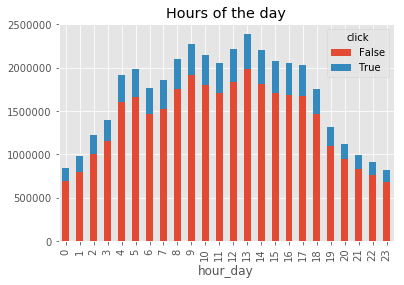

In [21]:
train_df.groupby(['hour_day', 'click']).size().unstack().plot(kind='bar', stacked=True, title="Hours of the day")

Clicks seem to follow the general traffic to websites.

### *banner_pos*

The banner position seem to be intuitively (paired with good design and envolving design) one of the good predictors for an ad CTR. Before further conclusions, the data format should be analysed:

In [22]:
train_df['banner_pos'].unique()

array([0, 1, 4, 5, 2, 7, 3], dtype=int64)

The *banner_pos* comes as an option among 7 integers, and it is not obvious of what it represents. We should not assume that is ordering has any meaning (it may very well be that each integer corresponds to a broad 2D position in a webpage). Lets see how it relates to clicks:

In [23]:
train_banner_pos_group_df = train_df.groupby(['banner_pos', 'click']).size().unstack()

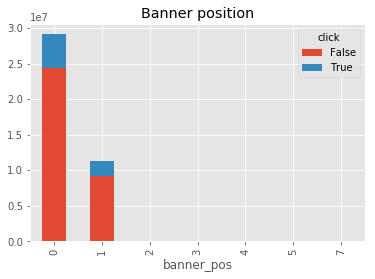

In [24]:
train_banner_pos_group_df.plot(kind='bar', stacked=True, title='Banner position')

Positions 0 and 1 seem to be the most used ones. We have to make another plot to gain insight over the other variables:

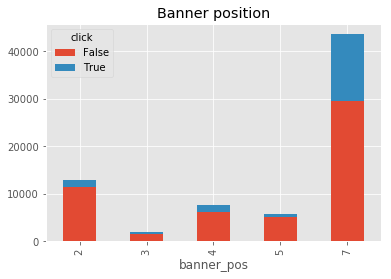

In [25]:
train_banner_pos_group_df.iloc[2:].plot(kind='bar', stacked=True, title='Banner position')

Position 7 seems to be very good for positioning ads.
These are the CTRs, normalized by banner position:

In [26]:
train_banner_pos_group_df / train_df.shape[0]

click,False,True
banner_pos,,
0,0.601739,0.118279
1,0.227117,0.051081
2,0.000283,0.000038
3,0.000041,0.000009
4,0.000155,0.000035
5,0.000126,0.000017
7,0.000733,0.000345


Now normalized by banner position:

In [27]:
train_banner_pos_group_df.div(train_banner_pos_group_df.sum(axis=1), axis=0)

click,False,True
banner_pos,,
0,0.835728,0.164272
1,0.816386,0.183614
2,0.880778,0.119222
3,0.817199,0.182801
4,0.814642,0.185358
5,0.878505,0.121495
7,0.679900,0.320100


Effectively, the CTR for position 7 is slightly above 32%. Positions 0, 1, 3 and 4 seem to be close contenders, with almost 20%, with the remainders slightly above 10%.

### Site-related features
Regarding the site, we have the features id, domain and category:

In [28]:
site_features = ['site_id', 'site_domain', 'site_category']

In [29]:
train_df[site_features].describe()

,site_id,site_domain,site_category
count,40428967,40428967,40428967
unique,4737,7745,26
top,85f751fd,c4e18dd6,50e219e0
freq,14596137,15131739,16537234


### App-related features
Regarding the app, we have the features id, domain and category:

In [30]:
app_features = ['app_id', 'app_domain', 'app_category']

In [31]:
train_df[app_features].describe()

,app_id,app_domain,app_category
count,40428967,40428967,40428967
unique,8552,559,36
top,ecad2386,7801e8d9,07d7df22
freq,25832830,27237087,26165592


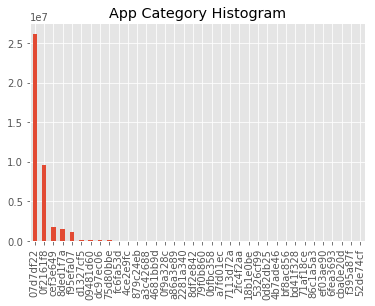

In [32]:
train_df['app_category'].value_counts().plot(kind='bar', title='App Category Histogram')

In [33]:
train_app_category_group_df = train_df.groupby(['app_category', 'click']).size().unstack()

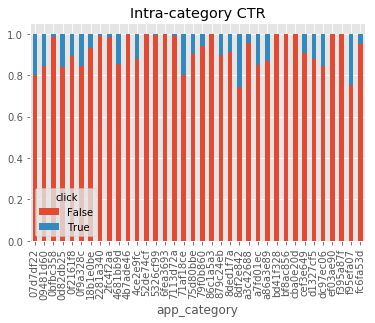

In [34]:
train_app_category_group_df.div(train_app_category_group_df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR")

### Device-related features
Regarding the device, we have the features id, ip, model, type and connection type:

In [35]:
device_features = ['device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type']

In [36]:
train_df[device_features].astype('object').describe()

,device_id,device_ip,device_model,device_type,device_conn_type
count,40428967,40428967,40428967,40428967,40428967
unique,2686408,6729486,8251,5,4
top,a99f214a,6b9769f2,8a4875bd,1,0
freq,33358308,208701,2455470,37304667,34886838


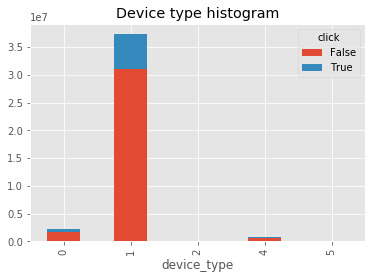

In [37]:
train_df.groupby(['device_type', 'click']).size().unstack().plot(kind='bar', stacked=True, title='Device type histogram')

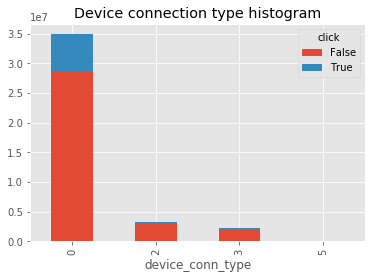

In [38]:
train_df.groupby(['device_conn_type', 'click']).size().unstack().plot(kind='bar', stacked=True, title='Device connection type histogram')

In what regards the devices, it would be interesting to create a dataframe where the rows are device_ids, and the columns correspond to historic characteristics of that device usage, like which site categories it visited. This information could be plugged in each row, joining the dataframes by device_id.

Due to time constraints, I was not able to further develop this topic. For an example of a project of mine see this [link](http://nbviewer.jupyter.org/github/diogojapinto/banking-project/blob/master/Banking%20Project%20-%20Diogo.ipynb) (bear in mind it was almost 2 years ago).

### C1, C14-C21
These are a couple of features whose identity was hidden, for annonimity reasons.

In [39]:
annonym_features = ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

In [40]:
train_df[annonym_features].astype('object').describe()

,C1,C14,C15,C16,C17,C18,C19,C20,C21
count,40428967,40428967,40428967,40428967,40428967,40428967,40428967,40428967,40428967
unique,7,2626,8,9,435,4,68,172,60
top,1005,4687,320,50,1722,0,35,65535,23
freq,37140632,948215,37708959,38136554,4513492,16939044,12170630,18937918,8896205


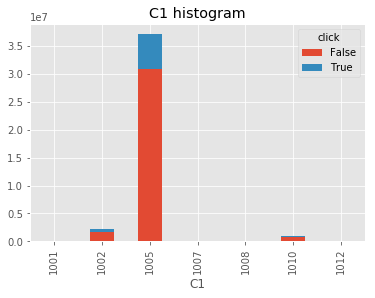

In [41]:
train_df.groupby(['C1', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')

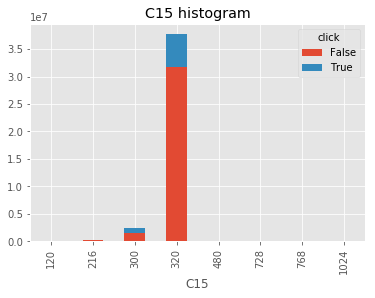

In [42]:
train_df.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C15 histogram')

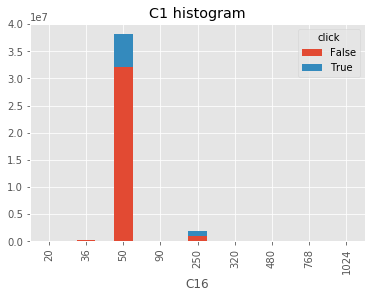

In [43]:
train_df.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C1 histogram')

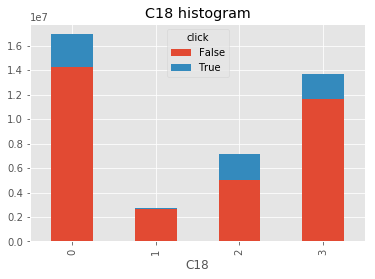

In [44]:
train_df.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 histogram')

## Prediction task

Provided the knowledge gathered in the previous stage, lets now dive in the prediction task.
Firstly, data must be prepared so that it can be fed to machine learning algorithms.

### Data preparation

These are the features that will be used at our prediction task:

In [45]:
features_mask = ['hour_int', 'day_week', 'hour_day', 'banner_pos', 'site_category']

In [46]:
target_mask = 'click'

Lets extract a sample from the data, to fasten computations:

In [47]:
train_sample_df = train_df[features_mask + [target_mask]].sample(frac=0.01, random_state=42)

We have to convert *site_category* into a format understandable by our classifiers.
Additionally, *banner_pos* is currently represented as an integer. We do not want our classification methods to be influenced by the arbitrary ordering that features has.
One-hot encoding will, therefore, be used:

In [48]:
def one_hot_obj_features(df, features):
    new_df = pd.get_dummies(df, columns=features, sparse=True)
    return new_df

In [49]:
train_sample_df = one_hot_obj_features(train_sample_df, ['site_category', 'banner_pos'])

Before moving one, we should extract a test set, that will only be touched at the time we obtain the model we will use, in order to estimate its performance with real-world data.

In [50]:
features_mask = np.array(train_sample_df.columns[train_sample_df.columns != target_mask].tolist())

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    train_sample_df[features_mask].values, 
    train_sample_df[target_mask].values,
    stratify=train_sample_df[target_mask],
    test_size=0.3,
    random_state=42
)

### Feature selection
In order to reduce our feature space into more manegeable size, as well as reduce overfitting, we will use grid-search cross-validation to obtain the tradeoff between number of features and F1-score, using logistic regression with L1 normalization.

Due to the unbalanced nature of the dataset, F1 score is a more appropriate performance measure than tradditional accuracy, as it corresponds to the harmonic mean between precision and recall.

By using L1 normalization in a logistic regression classifiers, the model is able to set the weights for a given set of features to 0, representing that its classification is not being influenced by those features.

Additionally, the classifier enables us to pass a parameter *class_weight* with the value *balanced* which enables it to modify the weight of each example according to the proportion of its target label (examples with label *click* will be weighted higher).

In [53]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score

In [54]:
n_splits = 3
c_values = np.logspace(-3, 0, 7)

In [55]:
skf_cv = StratifiedKFold(n_splits=n_splits)

In [56]:
scores = np.zeros(7)
nr_params = np.zeros(7)

In [57]:
for train_idx, valid_idx in skf_cv.split(X_train, y_train):
    for i, c in enumerate(np.logspace(-3, 0, 7)):
        # Fit the logistic regression model to the data
        lr_clf = LogisticRegression(penalty='l1', class_weight='balanced', C=c)
        lr_clf.fit(X_train[train_idx], y_train[train_idx])
        
        # Evaluate on validation set
        y_pred = lr_clf.predict(X_train[valid_idx])
        f1 = f1_score(y_train[valid_idx], y_pred, average='weighted')
        scores[i] += f1 / n_splits
        
        # Find which parameters were selected
        select_model = SelectFromModel(lr_clf, prefit=True)
        nr_params[i] += np.sum(select_model.get_support()) / n_splits
        

In [58]:
scores

array([ 0.52955264,  0.56583423,  0.59905472,  0.58368963,  0.57777875,
        0.57705737,  0.57629395])

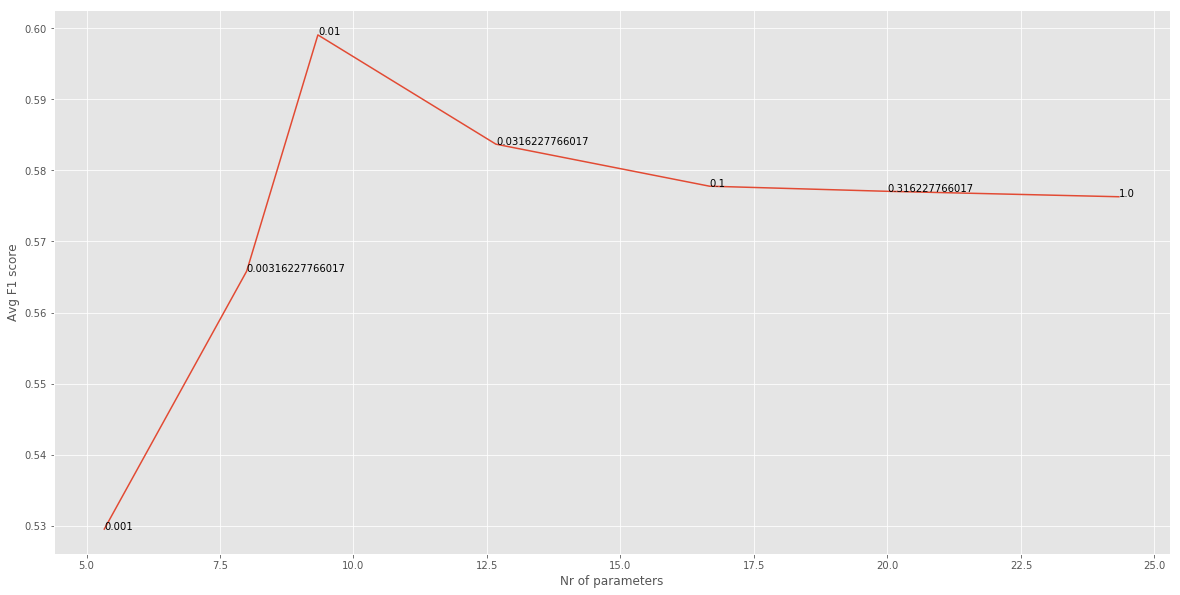

In [59]:
plt.figure(figsize=(20,10))
plt.plot(nr_params, scores)
for i, c in enumerate(c_values):
    plt.annotate(c, (nr_params[i], scores[i]))
plt.xlabel("Nr of parameters")
plt.ylabel("Avg F1 score")

It seems the parameters obtained using *c=0.01* manage to reduce parameters dimension (fastening execution time), while also improving generalization capacity.
Lets then re-fit the model, and extract prune our features list:

In [60]:
lr_clf = LogisticRegression(penalty='l1', class_weight='balanced', C=0.01)
lr_clf.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [61]:
select_model = SelectFromModel(lr_clf, prefit=True)
pruned_params = select_model.get_support()

In [62]:
features_mask = features_mask[pruned_params]

In [63]:
X_train = X_train[:, pruned_params]

In [64]:
X_test = X_test[:, pruned_params]

### Decision tree
In order to gain some intuition on the patterns found in data that are behind the prediction decisions, we can model a decision tree and visualize it. This kind of model is naturally interpretable.

In [65]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
dt_clf = DecisionTreeClassifier(min_samples_split=20, random_state=0, min_samples_leaf=2, max_depth=3, class_weight='balanced')

In [67]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

Next follows a piece of code that enables us to visualize the obtained tree (this step requires installation of GraphViz):

In [68]:
from sklearn import tree
from sklearn.externals.six import StringIO
import pydot as pydot
from IPython.display import Image

def display_tree(dtc_classifier):
    dot_data = StringIO()  
    tree.export_graphviz(dtc_classifier, out_file=dot_data,  
                         feature_names=features_mask,
                         class_names=target_mask,
                         filled=True,
                         rounded=True,
                         special_characters=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph[0].create_png())

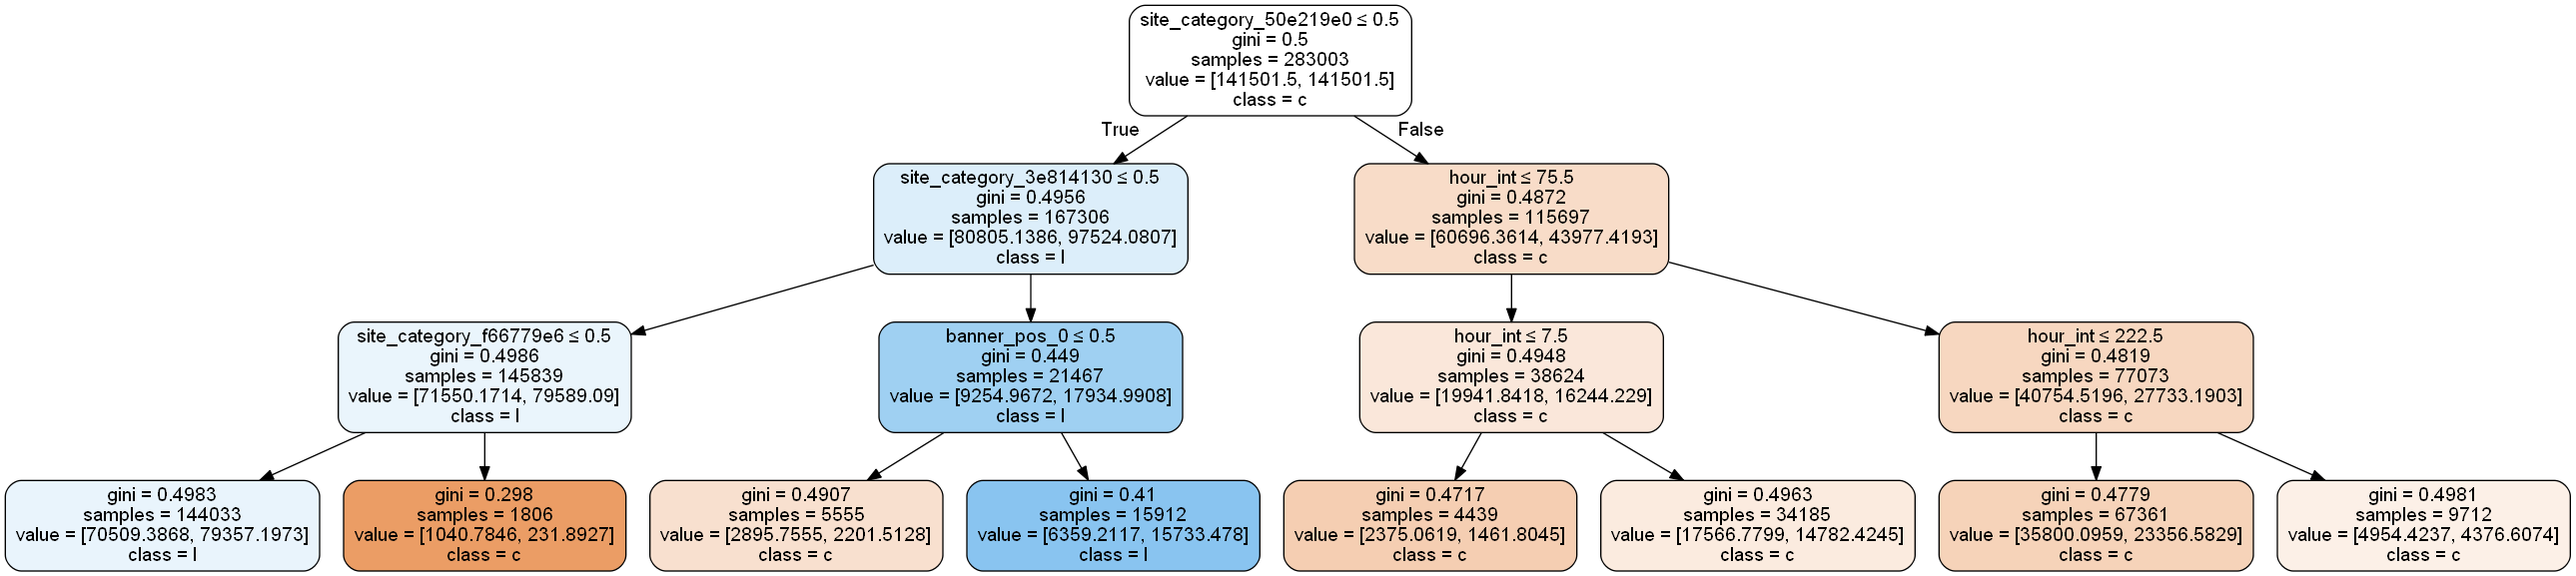

In [69]:
display_tree(dt_clf)

We are able to see that the site categories are recursively used to split the data. The tree also seeks to subset the time dimension into intervals to classify the data.

When analysing this tree, and due to the dataset dimension, it is important to remember that the tree height

### Gradient Boosting

In [70]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train,
    stratify=y_train,
    test_size=0.3,
    random_state=42
)

In [74]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=[(X_valid, y_valid)])
y_pred = xgb_clf.predict(X_test)
predictions = [round(value) for value in y_pred]

[0]	validation_0-logloss:0.65083
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.616369
[2]	validation_0-logloss:0.588061
[3]	validation_0-logloss:0.564684
[4]	validation_0-logloss:0.545263
[5]	validation_0-logloss:0.529107
[6]	validation_0-logloss:0.5156
[7]	validation_0-logloss:0.504296
[8]	validation_0-logloss:0.494866
[9]	validation_0-logloss:0.486947
[10]	validation_0-logloss:0.480333
[11]	validation_0-logloss:0.474815
[12]	validation_0-logloss:0.470202
[13]	validation_0-logloss:0.466341
[14]	validation_0-logloss:0.463125
[15]	validation_0-logloss:0.460436
[16]	validation_0-logloss:0.458211
[17]	validation_0-logloss:0.456341
[18]	validation_0-logloss:0.454769
[19]	validation_0-logloss:0.453434
[20]	validation_0-logloss:0.452025
[21]	validation_0-logloss:0.450851
[22]	validation_0-logloss:0.449887
[23]	validation_0-logloss:0.44919
[24]	validation_0-logloss:0.448527
[25]	validation_0-logloss:0.448071
[26]	validation_0-logloss:0.447703
[

In [77]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

      False       0.83      1.00      0.91    100627
       True       0.80      0.00      0.00     20660

avg / total       0.82      0.83      0.75    121287



## Predict for new data
Now is time to apply the classification algorithm to obtain predictions on unseen data.
We have to prepare the test dataset as we have done to the training dataset:

In [ ]:
def load_test_data():
    test_df = pd.read_csv('./data/test/test.csv',
                          dtype=data_types,
                          parse_dates=['hour'],
                          date_parser=date_parser)
    return test_df

In [ ]:
test_df = load_test_data()